In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

import numpy as np
import astropy.units as u
from pathlib import Path
import scipy.integrate as integrate
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from astropy.table import Table

# Load Gammapy modules

In [2]:
from gammapy.modeling import Fit
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.utils.random import get_random_state
 
# models modules
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets
)
from gammapy.maps import MapAxis, WcsGeom, Map, MapCoord
from gammapy.makers import MapDatasetMaker, SpectrumDatasetMaker

# Load GammaALP modules

In [3]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer

create ModuleList object for a given source

in this case NGC1275

for more details: https://github.com/me-manu/gammaALPs/blob/master/notebooks/example_NGC1275.ipynb

In [4]:
source     = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s') # this is for ngc1275

pin        = np.diag((1.,1.,0.)) * 0.5
alp        = ALP(0,0) 
modulelist = ModuleList(alp, source, pin = pin)
modulelist.add_propagation("ICMGaussTurb", 
              0, # position of module counted from the source. 
              nsim = 1, # number of random B-field realizations
              B0 = 10.,  # rms of B field
              n0 = 39.,  # normalization of electron density
              n2 = 4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
              r_abell = 500., # extension of the cluster
              r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
              r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
              beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
              beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
              eta = 0.5, # scaling of B-field with electron denstiy
              kL = 0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
              kH = 9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
              q = -2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
              seed=0 # random seed for reproducability, set to None for random seed.
             )
modulelist.add_propagation("EBL",1, model = 'dominguez') # EBL attenuation comes second, after beam has left cluster
modulelist.add_propagation("GMF",2, model = 'jansson12', model_sum = 'ASS') # finally, the beam enters the Milky Way Field
print(source)

environs.py: 432 --- INFO: Using inputted chi


kn.shape[0]= 220


environs.py:1043 --- INFO: Using inputted chi


# Load custom unbinned likelihood modules

In [5]:
from unbinned_lkl import (
    plot_counts_in_energy,
    previous_limits,
    FigSetup,
    compute_ALP_absorption,
    DifferentialCounts,
    GridLikelihood
    )




# ALP-ABSORBED GAMMA-RAY FLUX SIMULATION

## Steps to do:

# 1. 
We create an **observation** object from 
* pointing
* livetime
* irf

### IRF OF CTA SOUTH

In [6]:
pointing = SkyCoord(150.58 ,-13.26 , frame="icrs", unit="deg")
livetime = 5 * u.hr
irfs     = load_cta_irfs("C:/Users/fredr/gammapy-tutorials/datasets/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits")
observation = Observation.create( pointing=pointing, livetime=livetime, irfs=irfs)


background.py:  97 --- WARNING: Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


# 2.
We crate a custum Spectrum: **PWL  + ALP-absorption**

   core.py: 665 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 665 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 665 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 665 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>


ValueError: x and y must have same first dimension, but have shapes (200,) and (1, 200)

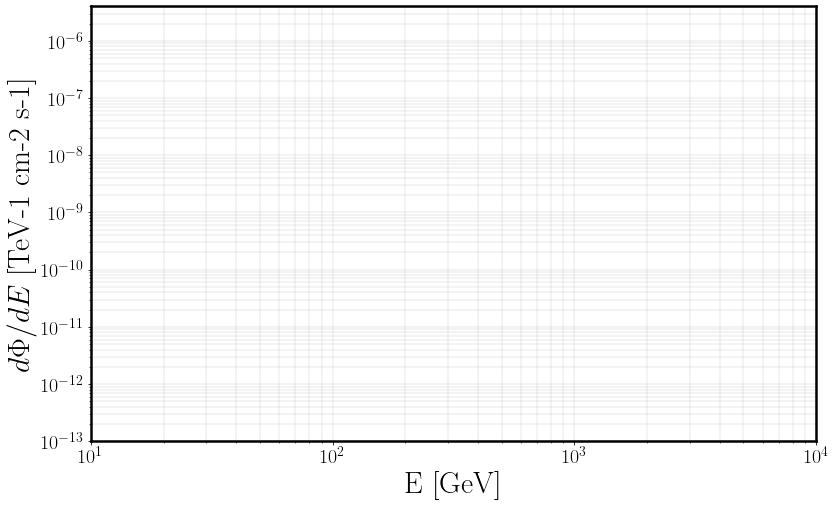

In [8]:
%%time
PWL_index = 2.11 # spectral index of the PWL
E0        = 300 # GeV
Ecut      = 560 # GeV
amplitude = 1.54 * 1e-9* u.Unit("TeV-1 cm-2 s-1") # 10e-6 

true_m = 0 * u.eV
true_g = 0 * 1/u.GeV

enpoints, pgg   = compute_ALP_absorption(
                    modulelist = modulelist, # modulelist from gammaALP
                    axion_mass = true_m, # neV
                    coupling   = true_g , # 10^(-11) /GeV
                    emin       = 10,  # Gev
                    emax       = 1e5, # GeV
                    bins       = 200) # log-bins in enrgy for which computing the ALP-absorption

enpoints, pggEBL = compute_ALP_absorption(
                    modulelist = modulelist, # modulelist from gammaALP
                    axion_mass = 0*u.neV, # neV
                    coupling   = 0*1e-11/u.GeV , # 10^(-11) /GeV
                    emin       = 10,  # Gev
                    emax       = 1e5, # GeV
                    bins       = 200) # log-bins in enrgy for which computing the ALP-absorption

pgg  *= np.sum(pggEBL)/np.sum(pgg)

PWL_flux        = amplitude*(enpoints/E0)**(-PWL_index)*np.exp(-enpoints/Ecut)

EBL_PWL_flux    = amplitude*pggEBL*(enpoints/E0)**(-PWL_index)*np.exp(-enpoints/Ecut)

ALP_PWL_flux    = amplitude*pgg*(enpoints/E0)**(-PWL_index)*np.exp(-enpoints/Ecut)

#############
# WE PLOT IT
############
#np.transpose(pgg)
plt.figure(figsize=(13,8))
plt.grid(True,which='both',linewidth=0.3)
plt.ylabel(r'$d\Phi / dE$  [TeV-1 cm-2 s-1]',size=30)
plt.xlabel('E [GeV]',size=30)
plt.xlim([1e1,1e4])
plt.ylim([1e-13,4e-6])
plt.xscale("log")
plt.yscale("log")
plt.plot(enpoints, ALP_PWL_flux,color="black", 
         label=r"intrinsic + EBL + ALP ( m = "+str(true_m.value)+"  $\cdot$  "+str(true_m.unit)+
                                    " ,  g = "+str(true_g.value)+"  $\cdot$  "+str(true_g.unit)+" )")

#plt.plot(enpoints, EBL_PWL_flux, "--",color="blue",
 #        label="intrinsic + EBL")

#plt.plot(enpoints, PWL_flux, "--",color="red",
#         label="intrinsic")

plt.legend(fontsize = 20)


In [11]:
print(EGeV.shape)

NameError: name 'EGeV' is not defined

# 3.
We create a **model** object from the custom Spectrum in Step 2

In [9]:
# We build the Source Model combining a Spectral and Spatial model
spectral_model      = TemplateSpectralModel(enpoints*u.Unit("GeV"),ALP_PWL_flux ,interp_kwargs={"method": "linear"}) 
spatial_model_point = PointSpatialModel(lon_0="150.58 deg", lat_0="-13.26 deg", frame="icrs")
sky_model_pntpwl    = SkyModel(spectral_model=spectral_model,spatial_model=spatial_model_point, name="point-pwl")
# we are not interested for now in simulateing the bkg so we comment this part
#bkg_model           = FoVBackgroundModel(dataset_name="my-dataset")

# finally we combine source and bkg models
models              = Models([sky_model_pntpwl]) # , bkg_model] )

# 4.
We now create a **Dataset** object from:
* the **observation**
* the **model**

In [15]:
%%time
energy_axis      = MapAxis.from_energy_bounds( "0.01 TeV", "100 TeV", nbin=15, per_decade=True, name="energy" )
energy_axis_true = MapAxis.from_energy_bounds( "0.01 TeV", "100 TeV", nbin=45, per_decade=True, name="energy_true")
migra_axis       = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

#  MapDatase
geom     = WcsGeom.create(frame="icrs", skydir=pointing, width=(2, 2), binsz=0.02, axes=[energy_axis])
d_empty  = MapDatasetOnOff.create( geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis, name="my-dataset")
maker    = MapDatasetMaker(selection=["exposure","edisp"]) # "background" 
dataset  = maker.run(d_empty, observation)
dataset.models = models


(200,)
Wall time: 2.73 s


# 5.
Finally we create the **DifferentialSourceCounts** object from the **Dataset**
in order to simulate energies in both true and estimate energy

Total expected counts of signal events in true energy : 83183.14232774448
Total expected counts of signal events in estimated energy : 83183.1423277445


C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


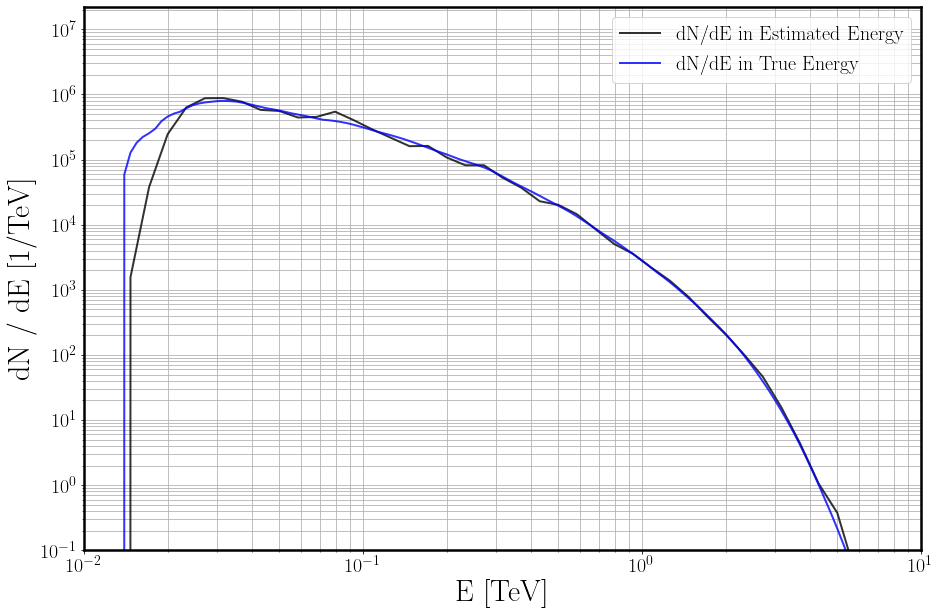

In [11]:
dnde  = DifferentialCounts(dataset)

# We Print the expected number of events in both true and estimated energy
print("Total expected counts of signal events in true energy : "+str(dnde.signal))
print("Total expected counts of signal events in estimated energy : "+str(dnde.signal_edisp))

#AND WE ALSO PLOT THE PREDICTED dN/dE
fig, ax = plt.subplots(figsize=(15,10))

plot_dict = dict(color='black',linewidth=2,alpha=0.8,label="dN/dE in Estimated Energy")
ax, fig = dnde.plot(ax=ax,fig=fig,estimated=True,**plot_dict,line=True)
plot_dict = dict(color='blue',linewidth=2,alpha=0.8, label="dN/dE in True Energy")
ax, fig = dnde.plot(ax=ax,fig=fig,estimated=False,**plot_dict,line=True)

ax.set_ylim(bottom=1e-1,top=None)
ax.set_xlim([1e-2,1e1])
ax.legend(fontsize=20)

# 6.
Events list simulation

83291
Wall time: 109 ms


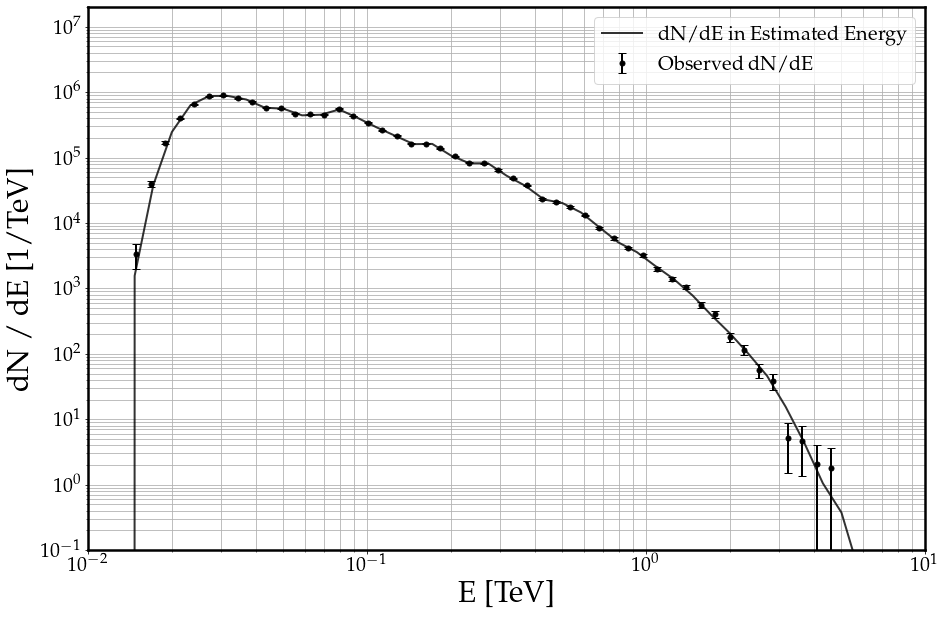

In [28]:
%%time
# WE SIMULATE THE EVENTS
envents_list = dnde.simulate_energies(estimated=True) # False if edisp effects are not considered
print(len(envents_list))

# WE PLOT THE SIMULATE COUNTS
fig, ax = plt.subplots(figsize=(15,10))

Emin, Emax    = np.min(envents_list), np.max(envents_list)
plot_dict = dict(color='black',label="Observed dN/dE")
ax      = plot_counts_in_energy(ax,envents_list.value, Emin.value,Emax.value,en_bins=50,**plot_dict)

#AND WE ALSO PLOT THE PREDICTED dN/dE
plot_dict = dict(color='black',linewidth=2,alpha=0.8,label="dN/dE in Estimated Energy")
ax, _ = dnde.plot(ax=ax,fig=fig,estimated=True,**plot_dict)

ax.set_ylim(bottom=1e-1)
ax.set_xlim([1e-2,1e1])
ax.legend(fontsize=20)




# LIKELIHOOD ANALYSIS



We first define the grid on the parameter space (m,g) on which we will compute the likelihood

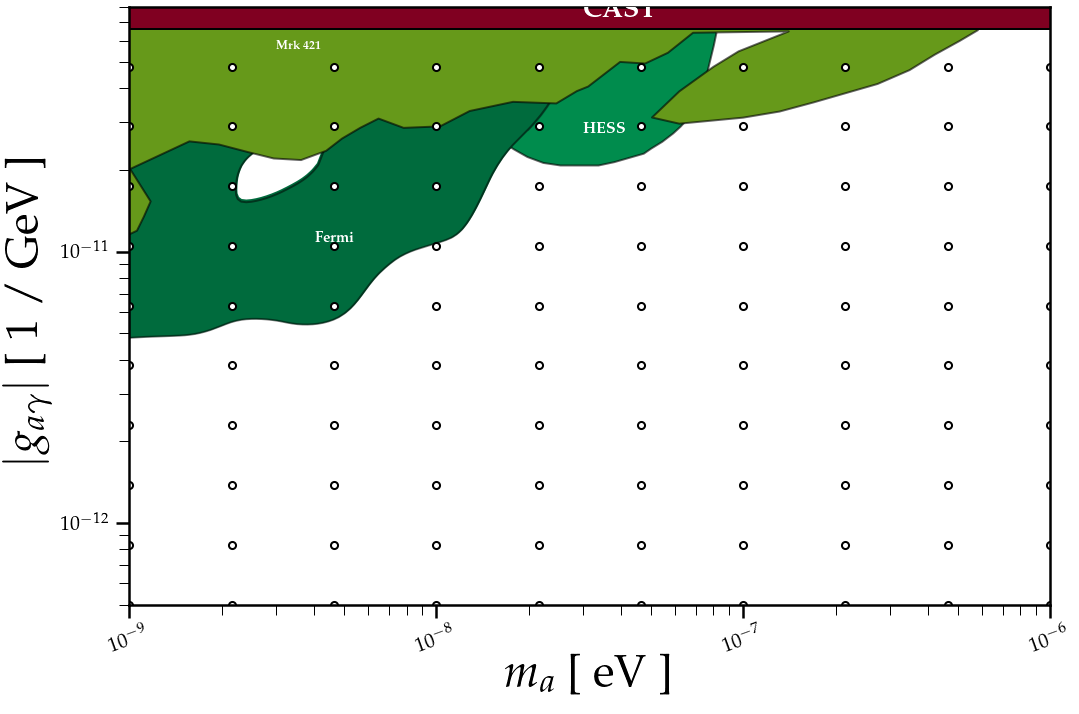

In [29]:
# range of m to explore
mass_list   = np.logspace( 0 ,3,10)*u.neV
# this unit convserion is neede for comparison with previous results
mass_list   = mass_list.to(u.eV)
# range of g to explore
g_list      = np.logspace(np.log10(0.05) , np.log10(8), 11)*1e-11/u.GeV

grid_points = np.meshgrid(mass_list,g_list)


# WE PLOT THE GRID M and G POITS WE WILL EXPLORE
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

# plot previous exclusion regions
previous_limits(ax)

#plot_likelihood(fig, ax, [mass_list,g_list],  scatter=True)
ax.scatter( grid_points[0],  grid_points[1], s=50, facecolors='white', edgecolors='black',linewidths=2)

### For each point of the grid we compute the predicted dN/dE function

In [30]:
%%time
# this might take some time dependeing on the number of points
dict_dnde = { }
        
for x,y in zip(  np.ravel( grid_points[0] )  , np.ravel( grid_points[1] ) ):
    if x.unit == u.eV:
        m = x
    elif x.unit == 1/u.GeV:
        g = x
    else:
        raise WalueError("Coordinates dimension should be eV for mass and 1/GeV for the coupling!")
        
    if y.unit == u.eV:
        m = y
    elif y.unit == 1/u.GeV:
        g = y
    else:
        raise WalueError("Coordinates dimension should be eV for mass and 1/GeV for the coupling!")

    enpoints, pgg   = compute_ALP_absorption(
                modulelist = modulelist, # modulelist from gammaALP
                axion_mass = m, 
                coupling   = g , 
                emin       = 10,  # Gev
                emax       = 1e5, # GeV
                bins       = 200) # log-bins in enrgy for which computing the ALP-absorption

    pgg  *= np.sum(pggEBL)/np.sum(pgg)

    ALP_PWL_flux        = amplitude*pgg*(enpoints/E0)**(-PWL_index)*np.exp(-enpoints/Ecut) #amplitude*pgg*enpoints**(-PWL_index)
    spectral_model      = TemplateSpectralModel(enpoints*u.Unit("GeV"),ALP_PWL_flux ,interp_kwargs={"method": "linear"}) 
    sky_model_pntpwl    = SkyModel(spectral_model=spectral_model,spatial_model=spatial_model_point, name="point-pwl")
    models              = Models([sky_model_pntpwl]) # , bkg_model] )
    dataset.models      = models
    idnde               = DifferentialCounts(dataset)
    dict_dnde[m,g]     = idnde

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function

   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\as

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>


Wall time: 5min 57s


C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\fredr\anaconda3\envs\gammapy-0.18.2\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### For each dN/dE above computed, given the observed events list, we can now compute the likelihood values

We first define the log of the likelihood function. In this case unbinned likelihood

In [31]:
def compute_unbinned_likelihood(x, dnde,**kwargs):
    s     = dnde.signal_edisp
    marks = dnde.get_dnde(x,estimated=True)

    return -s  + np.sum(np.log(marks))

We then use the *Class* **GridLikelihood** which takes in input the dN/dE fucntions per gridpoint and the likelihood function.

This class is needed for storing the likelihood values for each gridpoint, as well as the events list, the simulated TS and the CL

In [32]:
gg = GridLikelihood(dict_dnde, compute_unbinned_likelihood)
gg.events_list = envents_list
gg.get_TS_per_gridpoint()

### We plot the likelihood values

If we trust the Wilks' theorem the contour line at 6.0 (9.2) defined the excluded region at a CL of 95% (99%)

(<Figure size 1188x792 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2361b6e8550>)

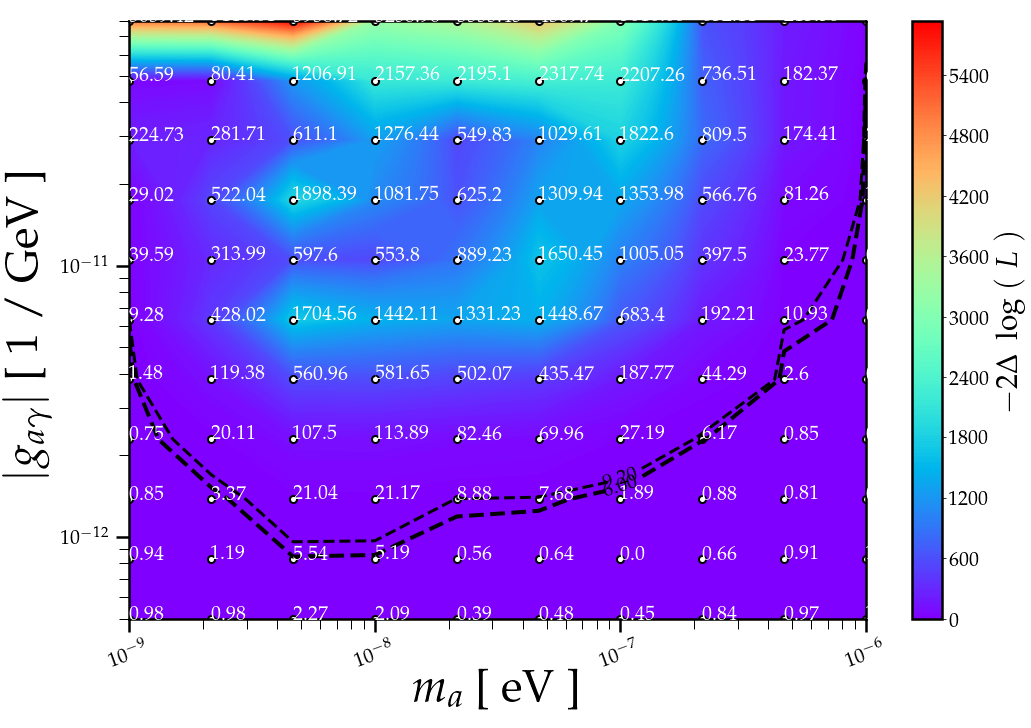

In [33]:
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

#ax = fig.add_subplot()
# According to the Wilks theorem a CL of 95 or 99 % is reached for TS 6.0 and 9.2
contour_dict = dict( colors=["black"] , levels=[ 6,9.2], linewidths=[4,3,2,1], linestyles="--" )               
gg.plot_grid(fig, ax,  what_to_plot = 'TS', show_map=True,scatter=True,show_values=True,**contour_dict)

Same plot but with only the contour lines over the previous known excluded region obtained by other experiments

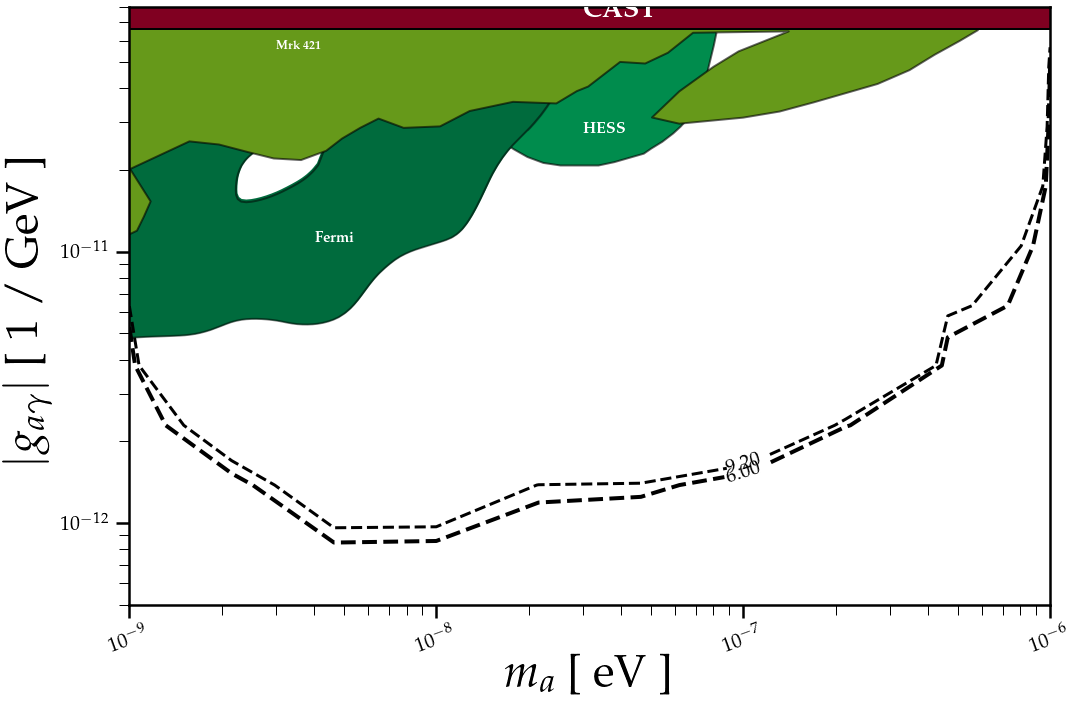

In [34]:
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

contour_dict = dict( colors=["black"] , levels=[ 6,9.2], linewidths=[4,3,2,1], linestyles="--" )
gg.plot_grid(fig, ax, what_to_plot = 'TS', show_map=False,**contour_dict)

# plot previous exclusion regions
previous_limits(ax)

## What if we do not trust the Wilks theorem!?

We need to compute the TS pdf by "hand", i.e. with MC simulations

In priciple we should simulate as many as possible TS values for each gridpoint (i.e. for any hypotesis) and from these distribution get the CL in each gridpoint

In practice this is not doable, unless the simulation for each gridpoint is fast!

So let's check how much it will take for simulating - let's say - 1 TS values for a single hypotesis (i.e. for a single gridpoint) 

In [37]:
%%time
# we just select one point of the grid point
# in this case the first one
which_points = [list(dict_dnde.keys())[0]]
gg.get_sim_TSs_per_gridpoint(number_of_simulations_per_point=1,which_points=which_points)

1 / 1 ... 
We are simulating 1 TS values for gridpoint (<Quantity 1.e-09 eV>, <Quantity 5.e-13 1 / GeV>)
Wall time: 733 ms


multiply it for the total number of gridpoints and the total numer of simulations you want to perform per each gridpoint

In [38]:
time = 733 *u.ms
total_grid_points = len(gg.TS_per_gridpoint)
number_of_simulations_per_point = 100
print( "The total simualtion will take: "+str(time.to(u.minute)*total_grid_points*number_of_simulations_per_point))

The total simualtion will take: 134.38333333333335 min


If you think this can be done, let's do it!

In [ ]:
%%time
# Firts we clear the previous computed simulated TS
gg.sim_TSs_per_gridpoint = None
# Now we run the TS simulation for each grid point
gg.get_CL_per_gridpoint(number_of_simulations_per_point=100)

1 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 1.e-09 eV>, <Quantity 5.e-13 1 / GeV>)
2 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 2.15443469e-09 eV>, <Quantity 5.e-13 1 / GeV>)
3 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 4.64158883e-09 eV>, <Quantity 5.e-13 1 / GeV>)
4 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 1.e-08 eV>, <Quantity 5.e-13 1 / GeV>)
5 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 2.15443469e-08 eV>, <Quantity 5.e-13 1 / GeV>)
6 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 4.64158883e-08 eV>, <Quantity 5.e-13 1 / GeV>)
7 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 1.e-07 eV>, <Quantity 5.e-13 1 / GeV>)
8 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 2.15443469e-07 eV>, <Quantity 5.e-13 1 / GeV>)
9 / 110 ... 
We are simulating 100 TS values for gridpoint (<Quantity 4.64158883e-07 eV>

We can check the CDF of the simulated TS values for each grid point and compare it with the Chi2 cdf (in black)

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19600a8e6d8>)

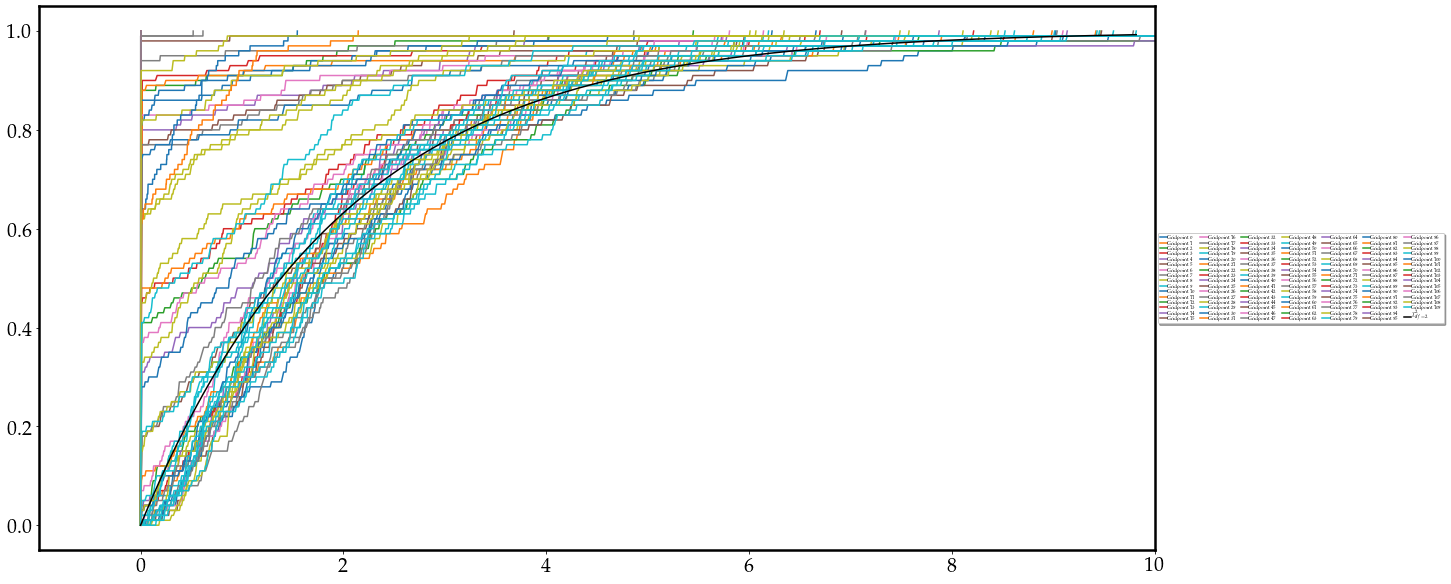

In [26]:
fig,ax = plt.subplots(figsize=(20,10))
ax.set_xlim(-1,10)
gg.plot_cdf(fig,ax)

### Below we plot the CL regions

ValueError: No CL values for each grid point! Please run 'get_CL_per_gridpoint'

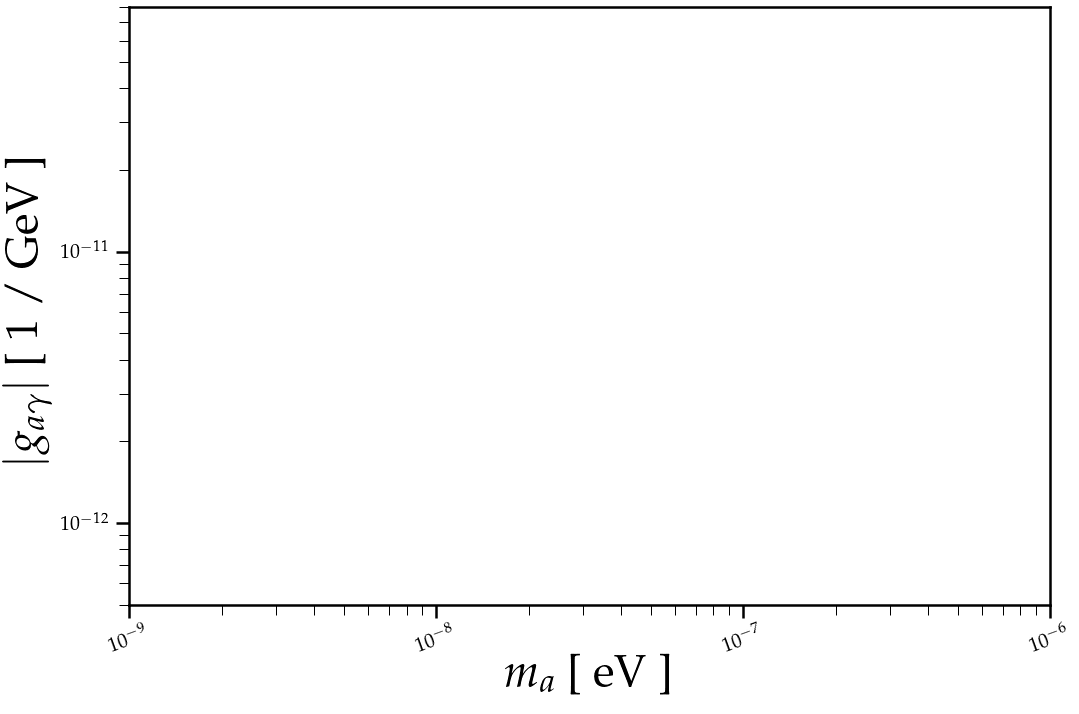

In [39]:
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

#ax = fig.add_subplot()
contour_dict = dict( colors=["black"] , levels=[ 0.95,0.99], linewidths=[4,3,2,1], linestyles="--" )               
gg.plot_grid(fig, ax,  what_to_plot = 'CL', show_map=True,scatter=True,show_values=True,**contour_dict)

ValueError: No CL values for each grid point! Please run 'get_CL_per_gridpoint'

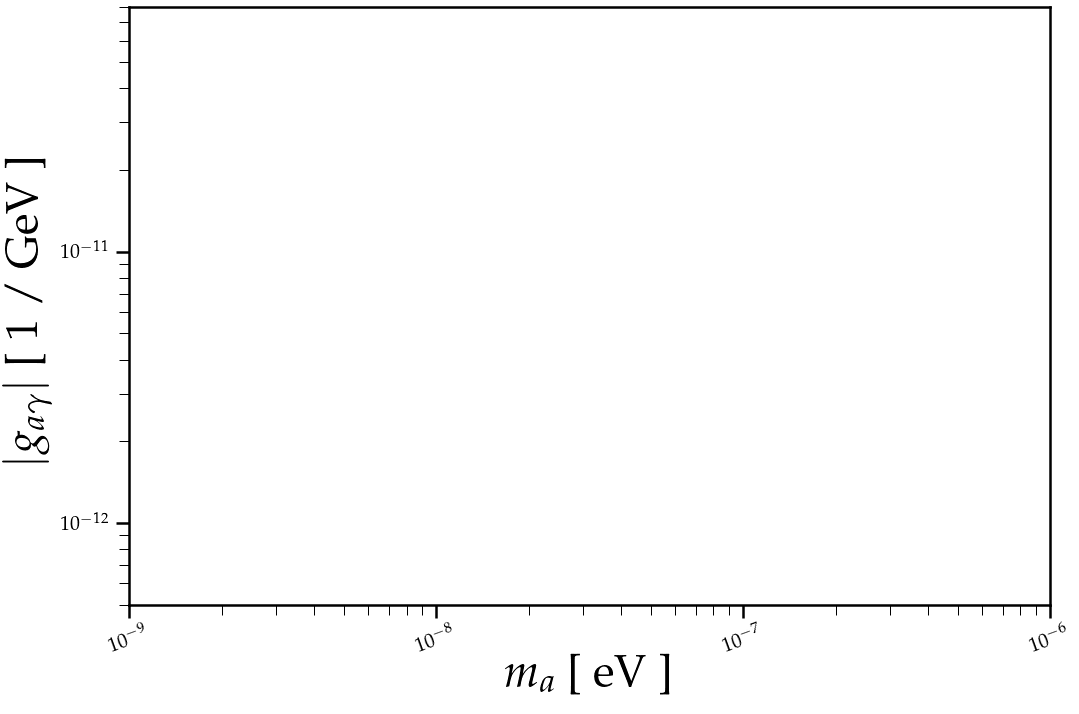

In [40]:
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

contour_dict = dict( colors=["black"] , levels=[ 0.95,0.99], linewidths=[4,3,2,1], linestyles="--" )
gg.plot_grid(fig, ax, what_to_plot = 'CL', show_map=False,**contour_dict)


# plot previous exclusion regions
previous_limits(ax)

# We can re-compute the CL regions for a new simulated events list
# in a very few steps!

In [52]:
envents_list = dnde.simulate_energies(estimated=True)
gg.events_list = envents_list
gg.get_TS_per_gridpoint()
gg.get_CL_per_gridpoint()

(<Figure size 1188x792 with 2 Axes>,
 <AxesSubplot:xlabel='$m_a$ [ eV ] ', ylabel='$|g_{a\\gamma}|$ [ 1 / GeV ] '>)

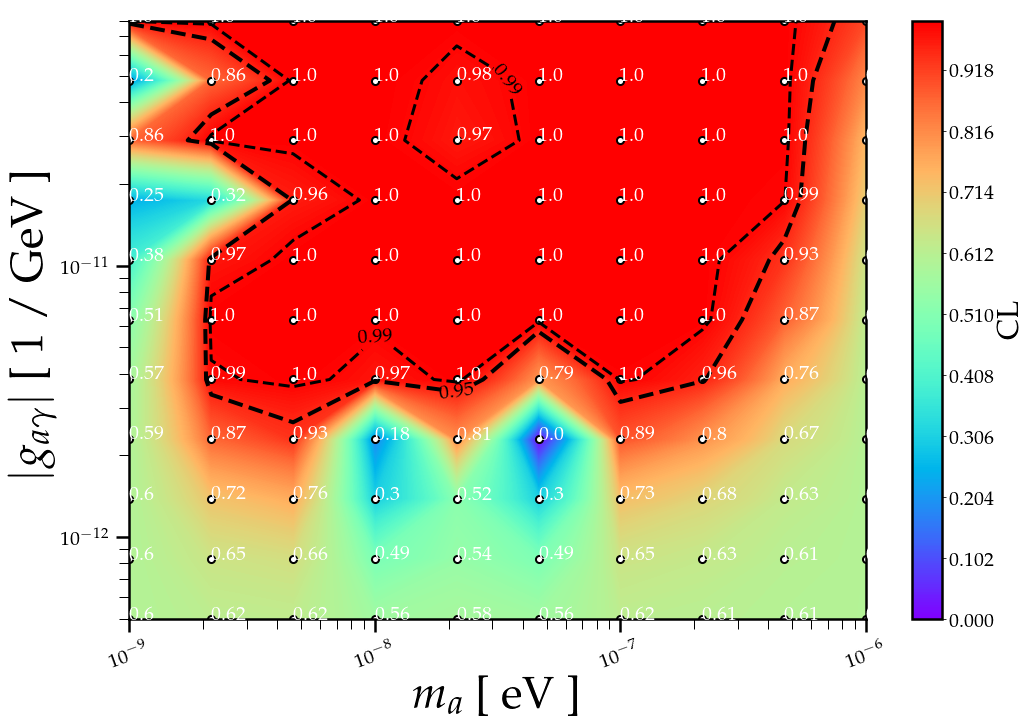

In [53]:
# PLOT THE RESULT
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

#ax = fig.add_subplot()
contour_dict = dict( colors=["black"] , levels=[ 0.95,0.99], linewidths=[4,3,2,1], linestyles="--" )               
gg.plot_grid(fig, ax,  what_to_plot = 'CL', show_map=True,scatter=True,show_values=True,**contour_dict)

<AxesSubplot:xlabel='$m_a$ [ eV ] ', ylabel='$|g_{a\\gamma}|$ [ 1 / GeV ] '>

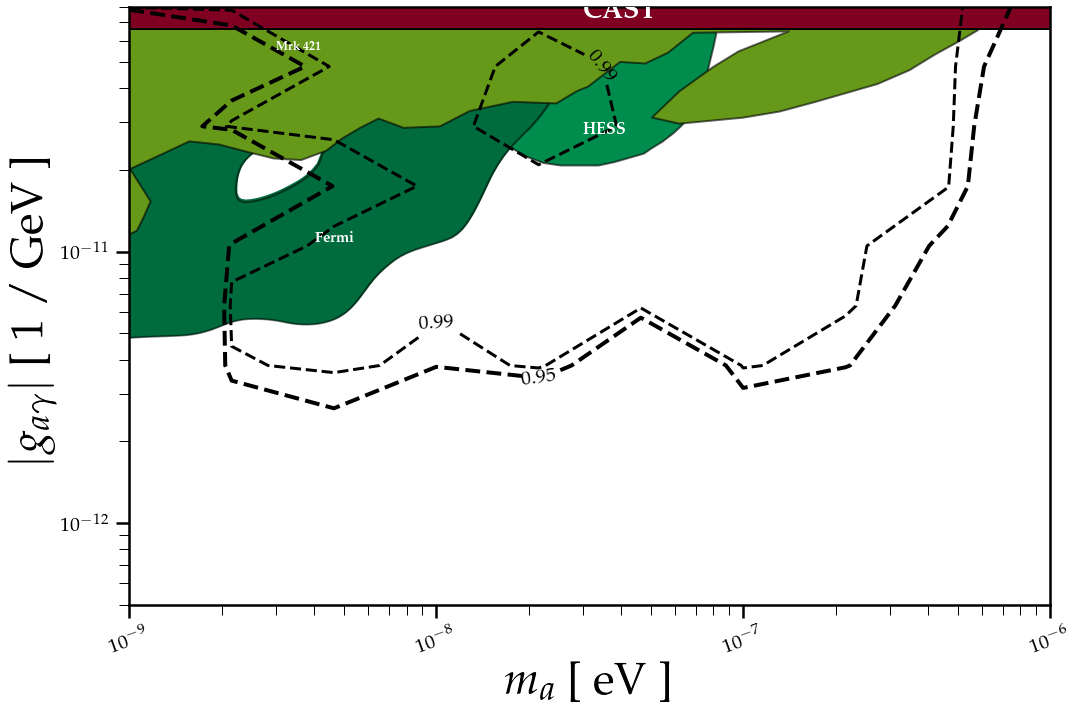

In [54]:
fig,ax = FigSetup(Shape='Rectangular',
                    xunit = str(mass_list.unit),
                    yunit = str(g_list.unit),
                    mathpazo=True,
                    g_min=np.min(g_list.value), g_max=np.max(g_list.value),
                    m_min=np.min(mass_list.value ), m_max=np.max(mass_list.value))

contour_dict = dict( colors=["black"] , levels=[ 0.95,0.99], linewidths=[4,3,2,1], linestyles="--" )
gg.plot_grid(fig, ax, what_to_plot = 'CL', show_map=False,**contour_dict)

# plot previous exclusion regions
previous_limits(ax)